# 📌 1️⃣ Install Dependencies

In [1]:
!pip install tensorflow numpy pandas opencv-python matplotlib tqdm scikit-learn albumentations

# 📌 2️⃣ Import Necessary Libraries

In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import albumentations as A
import shutil
import random

2025-05-20 09:44:10.765882: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747734250.970386      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747734251.027036      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# 🔍 Image Collection of Selected Classes (AMD,DME,NORMAL)

In [3]:
# MAKING THE TARGET DIRECTORIES
!mkdir -p /kaggle/working/df/DME
!mkdir -p /kaggle/working/df/AMD
!mkdir -p /kaggle/working/df/NORMAL

# COPY THE FILES FOR OUR CLASSESS FORM TRAIN,TEST,VAL FOLDERS
!cp -r /kaggle/input/retinal-oct-c8/RetinalOCT_Dataset/RetinalOCT_Dataset/train/DME/* /kaggle/working/df/DME/
!cp -r /kaggle/input/retinal-oct-c8/RetinalOCT_Dataset/RetinalOCT_Dataset/train/AMD/* /kaggle/working/df/AMD/
!cp -r /kaggle/input/retinal-oct-c8/RetinalOCT_Dataset/RetinalOCT_Dataset/train/NORMAL/* /kaggle/working/df/NORMAL/
!cp -r /kaggle/input/retinal-oct-c8/RetinalOCT_Dataset/RetinalOCT_Dataset/test/DME/* /kaggle/working/df/DME/
!cp -r /kaggle/input/retinal-oct-c8/RetinalOCT_Dataset/RetinalOCT_Dataset/test/AMD/* /kaggle/working/df/AMD/
!cp -r /kaggle/input/retinal-oct-c8/RetinalOCT_Dataset/RetinalOCT_Dataset/test/NORMAL/* /kaggle/working/df/NORMAL/
!cp -r /kaggle/input/retinal-oct-c8/RetinalOCT_Dataset/RetinalOCT_Dataset/val/DME/* /kaggle/working/df/DME/
!cp -r /kaggle/input/retinal-oct-c8/RetinalOCT_Dataset/RetinalOCT_Dataset/val/AMD/* /kaggle/working/df/AMD/
!cp -r /kaggle/input/retinal-oct-c8/RetinalOCT_Dataset/RetinalOCT_Dataset/val/NORMAL/* /kaggle/working/df/NORMAL/


# 📌 3️⃣ Load and Inspect Dataset

In [4]:
dataset_path = "/kaggle/working/df"

# DEFINE CLASS LABELS
class_labels = ["AMD", "DME", "NORMAL"]

# DATASET STRUCTURE
for folder in class_labels:
    folder_path = os.path.join(dataset_path, folder)
    if os.path.isdir(folder_path):
        print(f"{folder}: {len(os.listdir(folder_path))} images")

AMD: 3000 images
DME: 3000 images
NORMAL: 3000 images


# 🔍 Sample Original Images (3 Per Class)

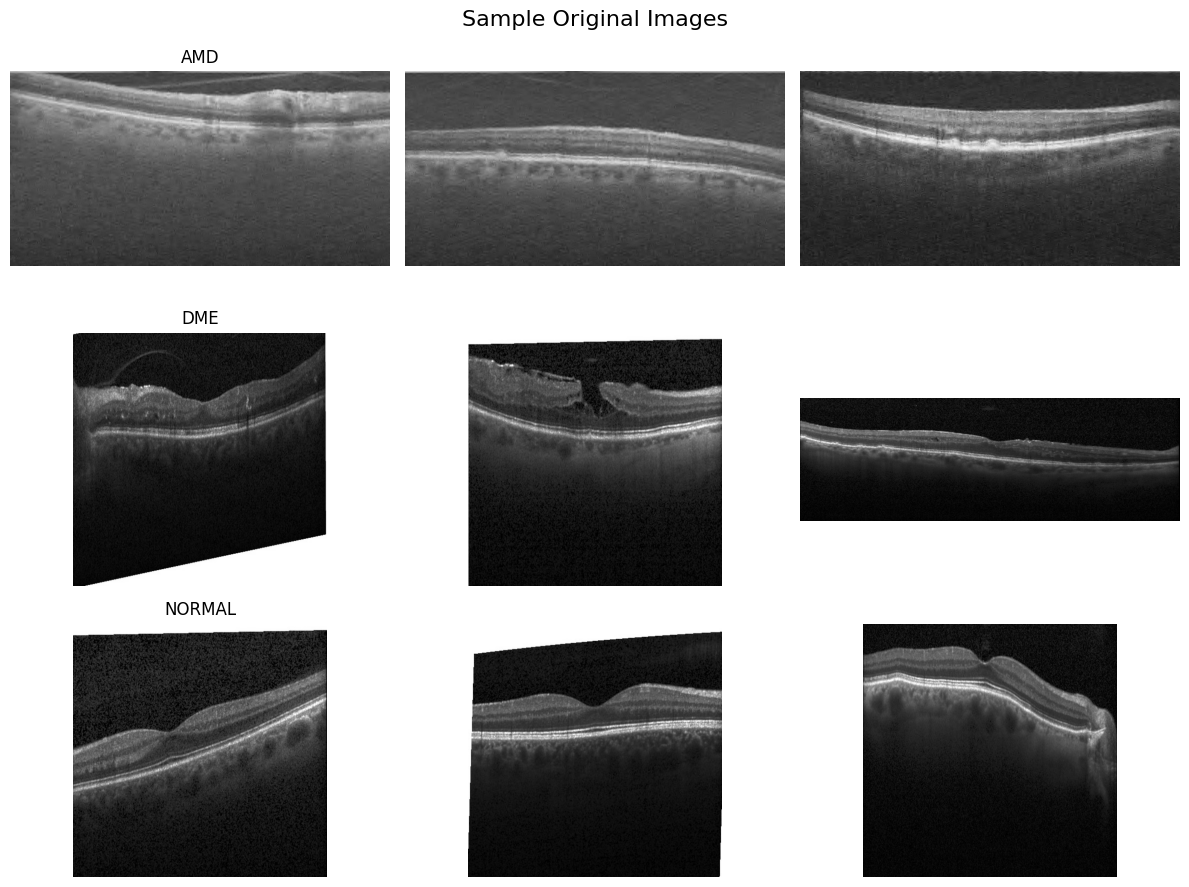

In [5]:
fig, axes = plt.subplots(len(class_labels), 3, figsize=(12, 9))

for row, folder in enumerate(class_labels):
    folder_path = os.path.join(dataset_path, folder)
    images = os.listdir(folder_path)
    selected = random.sample(images, 3) if len(images) >= 3 else images

    for col, img_name in enumerate(selected):
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        axes[row, col].imshow(img)
        axes[row, col].axis("off")
        if col == 0:
            axes[row, col].set_title(folder)

plt.suptitle("Sample Original Images", fontsize=16)
plt.tight_layout()
plt.show()

# 📌 4️⃣ Preprocess Dataset

In [6]:
TARGET_SIZE = (224, 224)  
preprocessed_path = "/kaggle/working/Preprocessed_Data"
os.makedirs(preprocessed_path, exist_ok=True)

def preprocess_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Warning: Could not read image {image_path}")
        return None
    if len(img.shape) == 2 or img.shape[2] == 1:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    resized_img = cv2.resize(img, TARGET_SIZE)
    return resized_img

for folder in class_labels:
    folder_path = os.path.join(dataset_path, folder)
    save_folder = os.path.join(preprocessed_path, folder)
    os.makedirs(save_folder, exist_ok=True)

    for img_name in tqdm(os.listdir(folder_path), desc=f"Processing {folder}"):
        img_path = os.path.join(folder_path, img_name)
        processed_img = preprocess_image(img_path)
        if processed_img is not None:
            save_path = os.path.join(save_folder, img_name)
            cv2.imwrite(save_path, processed_img)

print("Preprocessing complete.")

Processing NORMAL: 100%|██████████| 3000/3000 [00:07<00:00, 427.19it/s]

Preprocessing complete.


# 🔍 Sample Preprocessed Images (3 Per Class)

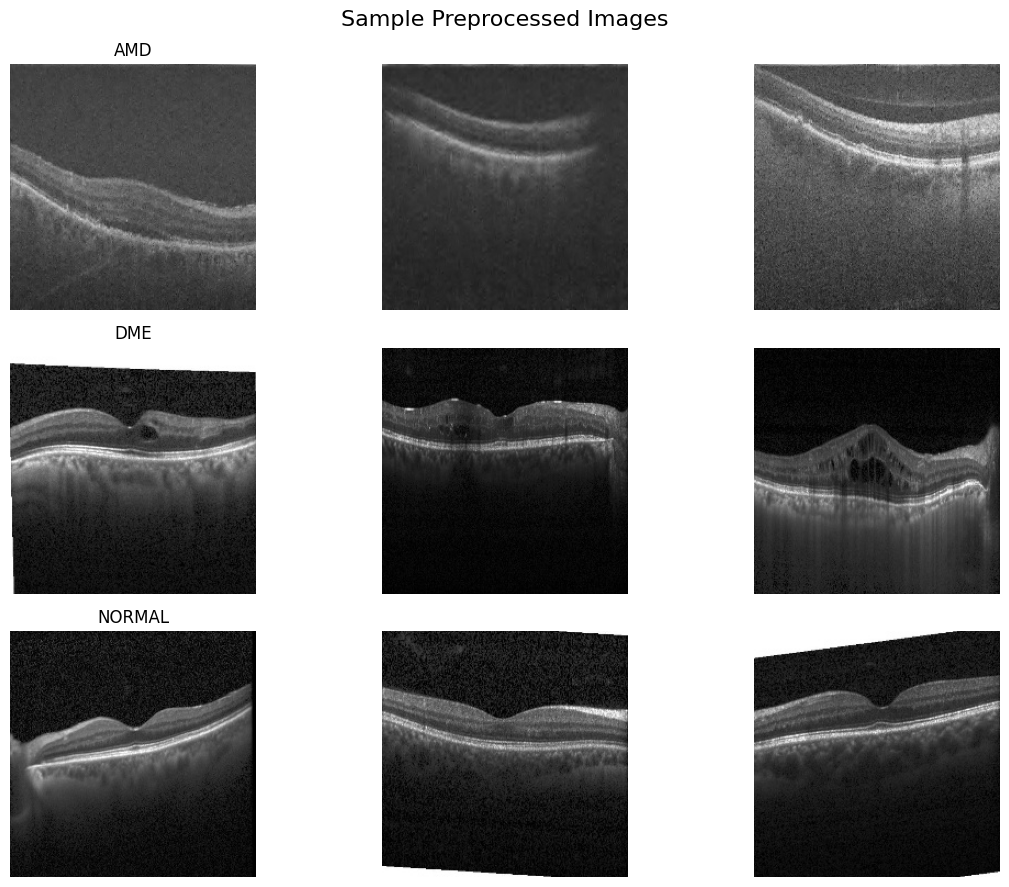

In [7]:
fig, axes = plt.subplots(len(class_labels), 3, figsize=(12, 9))

for row, folder in enumerate(class_labels):
    folder_path = os.path.join(preprocessed_path, folder)
    images = os.listdir(folder_path)
    selected = random.sample(images, 3) if len(images) >= 3 else images

    for col, img_name in enumerate(selected):
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        axes[row, col].imshow(img)
        axes[row, col].axis("off")
        if col == 0:
            axes[row, col].set_title(folder)

plt.suptitle("Sample Preprocessed Images", fontsize=16)
plt.tight_layout()
plt.show()

# 📌 5️⃣ Augmentation (To reach 1500 Per Class)

# ❗This data set already has 3000 pic per class so **Augmentation** will not be applied.

# 📌 6️⃣ Segmentation (Generate Threshold-Based Simulated Masks)

In [8]:
segmentation_masks_path = "/kaggle/working/Segmentation_Masks"
os.makedirs(segmentation_masks_path, exist_ok=True)

for folder in class_labels:
    mask_folder = os.path.join(segmentation_masks_path, folder)
    os.makedirs(mask_folder, exist_ok=True)

    image_folder = os.path.join(preprocessed_path, folder)
    for img_name in os.listdir(image_folder):
        img_path = os.path.join(image_folder, img_name)

        # READ GRAYSCALE
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        # APPLY ADAPTIVE THRESHOLDING
        mask = cv2.adaptiveThreshold(
            img,
            maxValue=255,
            adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            thresholdType=cv2.THRESH_BINARY,
            blockSize=11,
            C=2
        )

        mask_path = os.path.join(mask_folder, img_name)
        cv2.imwrite(mask_path, mask)

print("Segmentation masks created using intensity thresholding.")

Segmentation masks created using intensity thresholding.


# 🔍 Sample Segmentation Masks (3 Per Class)

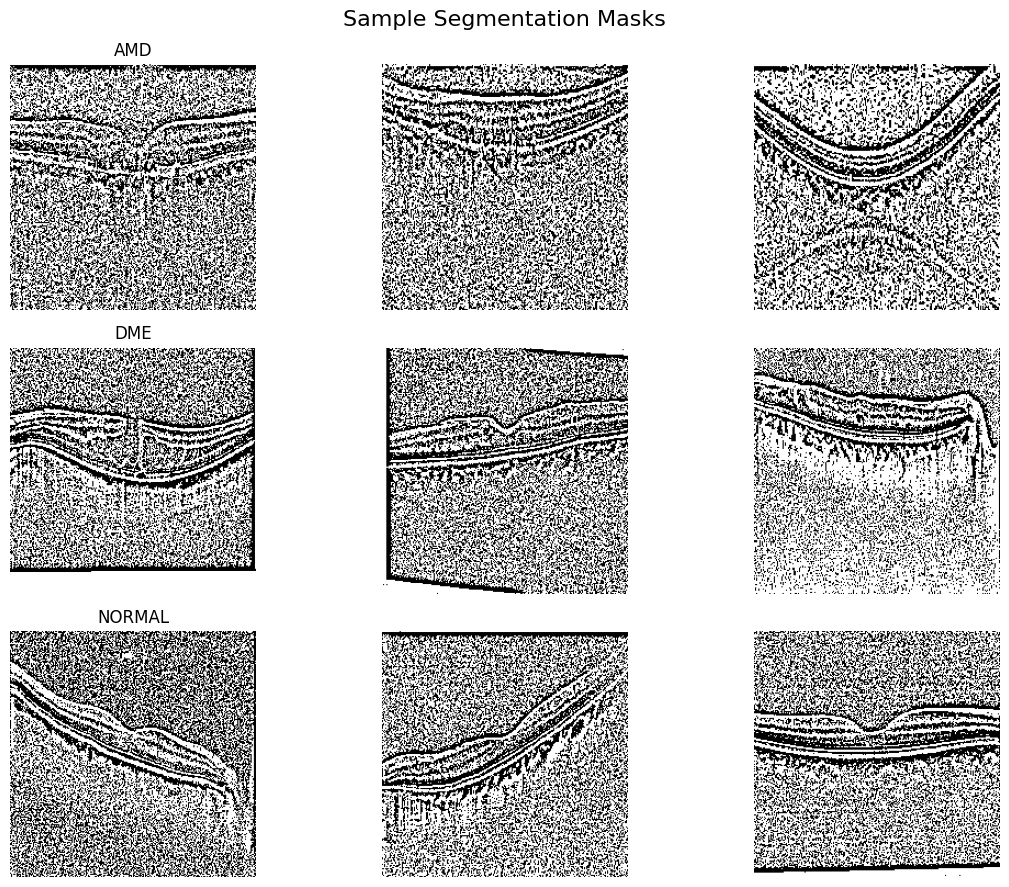

In [9]:
fig, axes = plt.subplots(len(class_labels), 3, figsize=(12, 9))

for row, folder in enumerate(class_labels):
    folder_path = os.path.join(segmentation_masks_path, folder)
    images = os.listdir(folder_path)
    selected = random.sample(images, 3) if len(images) >= 3 else images

    for col, img_name in enumerate(selected):
        img_path = os.path.join(folder_path, img_name)
        mask = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        axes[row, col].imshow(mask, cmap="gray")
        axes[row, col].axis("off")
        if col == 0:
            axes[row, col].set_title(folder)

plt.suptitle("Sample Segmentation Masks", fontsize=16)
plt.tight_layout()
plt.show()

# 📌 7️⃣ Train, Validation, and Test Split

In [10]:
train_ratio, val_ratio, test_ratio = 0.60, 0.20, 0.20

# DEFINE TRAIN, VALIDATION, TEST DIRECTORIES
train_path = os.path.join(preprocessed_path, "train")
val_path = os.path.join(preprocessed_path, "val")
test_path = os.path.join(preprocessed_path, "test")

#CREATE DIRECTORIES
for path in [train_path, val_path, test_path]:
    os.makedirs(path, exist_ok=True)

def split_dataset(folder):
    file_list = os.listdir(os.path.join(segmentation_masks_path, folder))
    np.random.shuffle(file_list)
    
    train_idx = int(len(file_list) * train_ratio)
    val_idx = int(len(file_list) * (train_ratio + val_ratio))
    
    return file_list[:train_idx], file_list[train_idx:val_idx], file_list[val_idx:]


for folder in class_labels:
    os.makedirs(os.path.join(train_path, folder), exist_ok=True)
    os.makedirs(os.path.join(val_path, folder), exist_ok=True)
    os.makedirs(os.path.join(test_path, folder), exist_ok=True)

    train_files, val_files, test_files = split_dataset(folder)

    for file in train_files:
        shutil.move(os.path.join(preprocessed_path, folder, file), os.path.join(train_path, folder, file))
    for file in val_files:
        shutil.move(os.path.join(preprocessed_path, folder, file), os.path.join(val_path, folder, file))
    for file in test_files:
        shutil.move(os.path.join(preprocessed_path, folder, file), os.path.join(test_path, folder, file))

print("Data split and moved to train/val/test folders successfully!")

Data split and moved to train/val/test folders successfully!


# 📌 8️⃣ Define Data Generators

In [11]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 5400 images belonging to 3 classes.
Found 1800 images belonging to 3 classes.
Found 1800 images belonging to 3 classes.


# 📌 9️⃣ Models Training

In [12]:
from tensorflow.keras.applications import ResNet152, InceptionV3,MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

#MODELS
models_to_train = {
    "ResNet152": ResNet152,
    "InceptionV3": InceptionV3,
    "MobileNetV2": MobileNetV2,
}

trained_models = {}
histories = {}
model_paths = {}

for name, base_model_fn in models_to_train.items():
    print(f"\nTraining model: {name}")

    base_model = base_model_fn(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(256, activation="relu")(x)
    x = Dropout(0.5)(x)
    output = Dense(len(class_labels), activation="softmax")(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

    path = f"/kaggle/working/best_{name.lower()}_model.keras"
    model_paths[name] = path

    checkpoint = ModelCheckpoint(
        path, monitor="val_accuracy", save_best_only=True, mode="max", verbose=1
    )

    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=20,
        batch_size=32,
        callbacks=[checkpoint]
    )

    trained_models[name] = model
    histories[name] = history


Training model: ResNet152


I0000 00:00:1747734411.726114      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


234698864/234698864 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1747734558.866174     104 service.cc:148] XLA service 0x7aa2c80048e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747734558.866900     104 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1747734572.018205     104 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1747734611.215971     104 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 653ms/step - accuracy: 0.8750 - loss: 0.3034
Epoch 1: val_accuracy improved from -inf to 0.33333, saving model to /kaggle/working/best_resnet152_model.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 328s 802ms/step - accuracy: 0.8754 - loss: 0.3026 - val_accuracy: 0.3333 - val_loss: 1.1434
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.9867 - loss: 0.0462
Epoch 2: val_accuracy did not improve from 0.33333
169/169 ━━━━━━━━━━━━━━━━━━━━ 71s 417ms/step - accuracy: 0.9867 - loss: 0.0462 - val_accuracy: 0.3333 - val_loss: 1.4664
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.9918 - loss: 0.0231
Epoch 3: val_accuracy did not improve from 0.33333
169/169 ━━━━━━━━━━━━━━━━━━━━ 71s 418ms/step - accuracy: 0.9918 - loss: 0.0231 - val_accuracy: 0.3328 - val_loss: 1.3896
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.9892 - loss: 0.0414
Epoch 4: val_accuracy improved from 0.33333 to 0.34556, saving model to /kaggle/work

E0000 00:00:1747736843.493776     104 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1747736843.690289     104 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


148/169 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.8030 - loss: 0.4541

E0000 00:00:1747736874.437760     103 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1747736874.636685     103 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.8157 - loss: 0.4271
Epoch 1: val_accuracy improved from -inf to 0.66889, saving model to /kaggle/working/best_mobilenetv2_model.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 96s 242ms/step - accuracy: 0.8162 - loss: 0.4260 - val_accuracy: 0.6689 - val_loss: 1.2891
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9793 - loss: 0.0562
Epoch 2: val_accuracy improved from 0.66889 to 0.72556, saving model to /kaggle/working/best_mobilenetv2_model.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 16s 94ms/step - accuracy: 0.9793 - loss: 0.0562 - val_accuracy: 0.7256 - val_loss: 1.2339
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9924 - loss: 0.0229
Epoch 3: val_accuracy improved from 0.72556 to 0.81056, saving model to /kaggle/working/best_mobilenetv2_model.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 16s 95ms/step - accuracy: 0.9924 - loss: 0.0229 - val_accuracy: 0.8106 - val_loss: 0.8605
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 

# 🔍 Training and Validation Curves

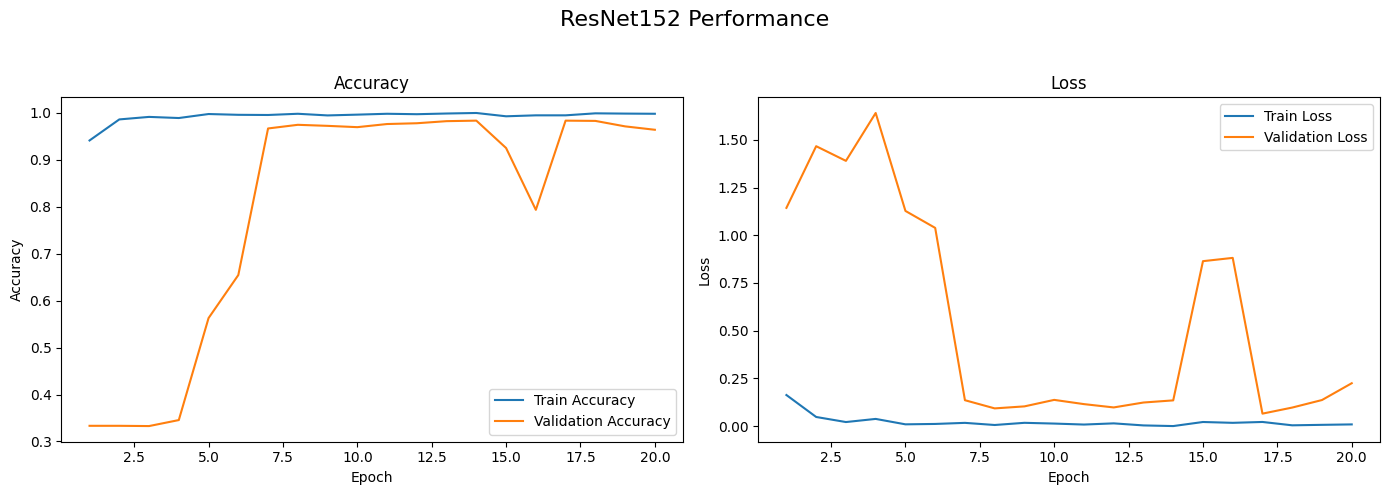

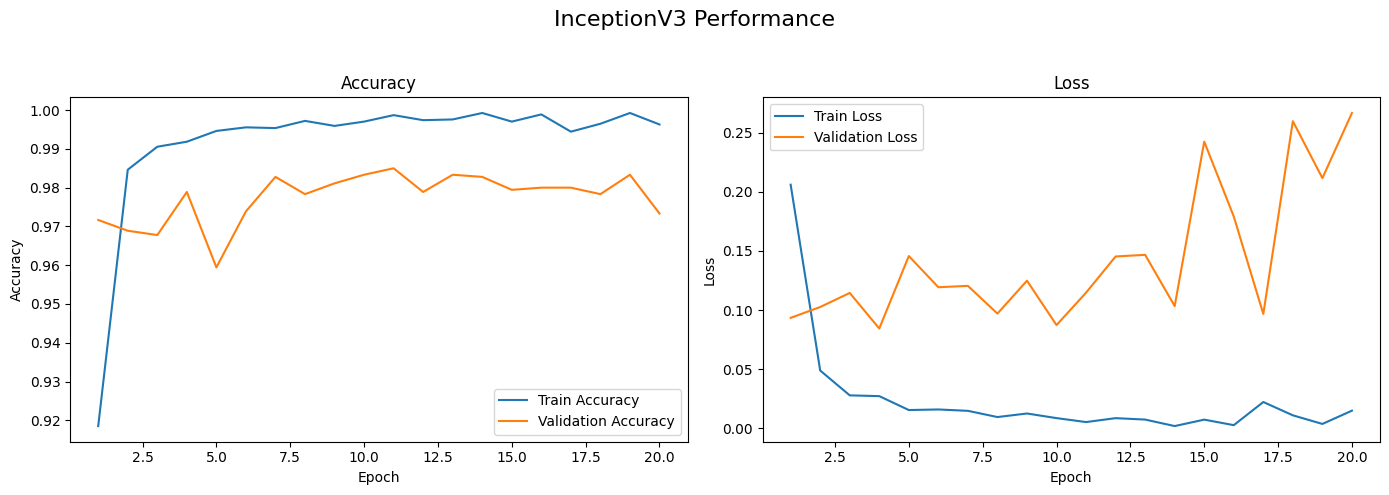

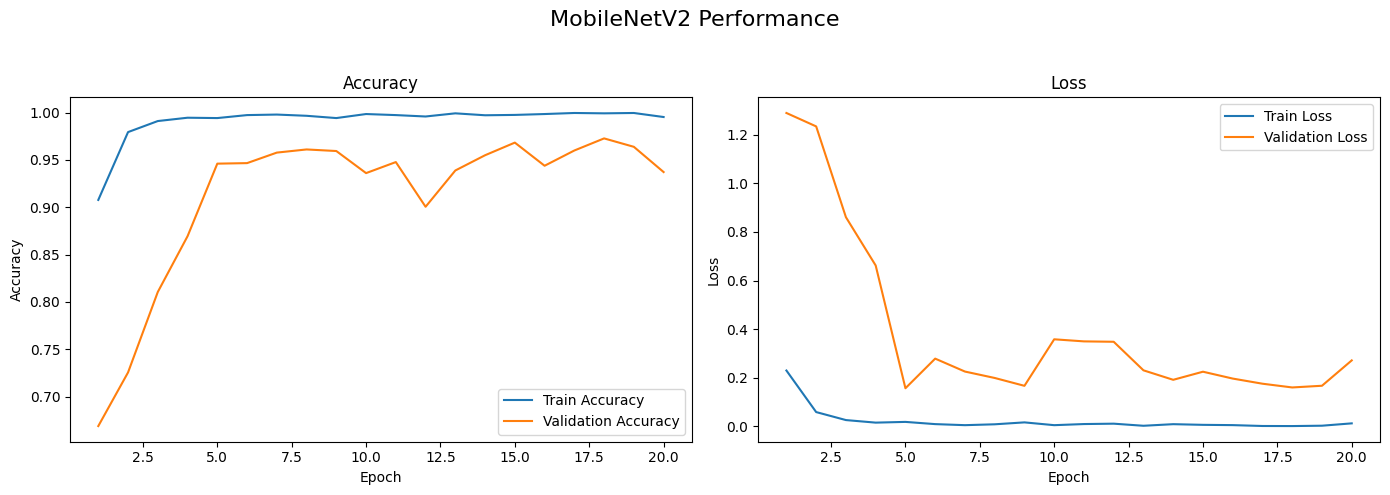

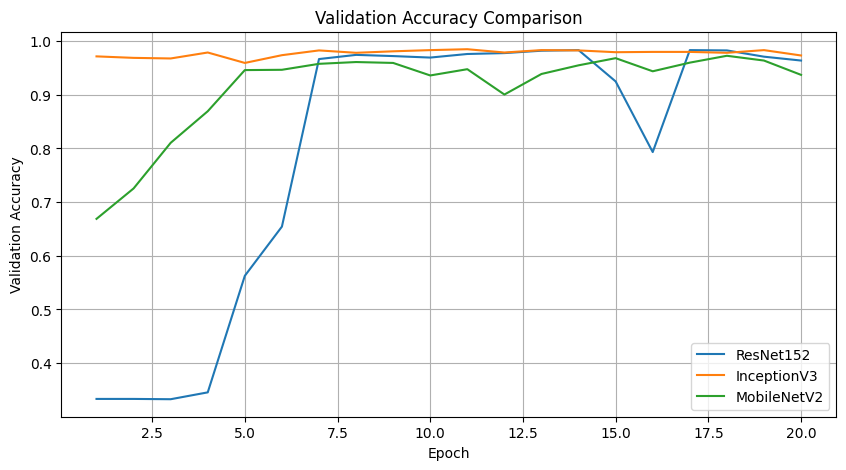

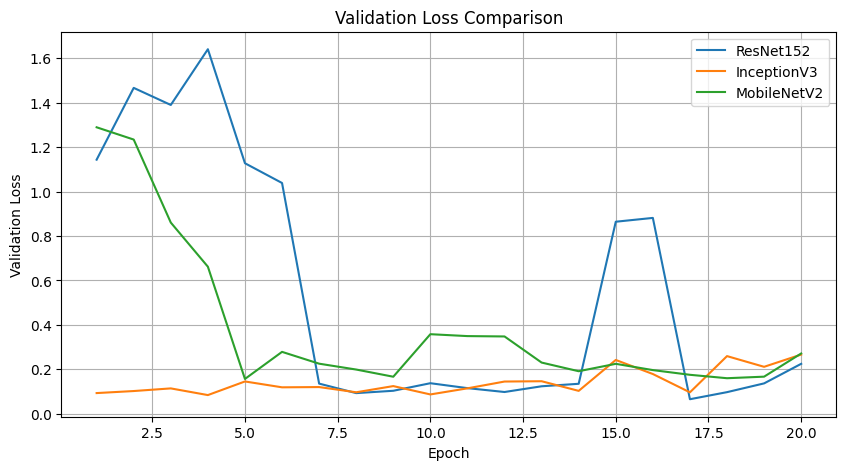

In [13]:
import matplotlib.pyplot as plt

#PLOT ACCURACY AND LOSS FOR EACH MODEL INDIVIDUALLY
for name, history in histories.items():
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))
    plt.suptitle(f"{name} Performance", fontsize=16)

    #ACCURACY
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Train Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    #LOSS
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


#VALIDATION ACCURACY COMPARISON
plt.figure(figsize=(10, 5))
for name, history in histories.items():
    val_acc = history.history['val_accuracy']
    plt.plot(range(1, len(val_acc) + 1), val_acc, label=name)
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

#VALIDATION LOSS COMPARISON
plt.figure(figsize=(10, 5))
for name, history in histories.items():
    val_loss = history.history['val_loss']
    plt.plot(range(1, len(val_loss) + 1), val_loss, label=name)
plt.title('Validation Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# 📌 🔟 Performance Evaluation 


Evaluating ResNet152


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


57/57 ━━━━━━━━━━━━━━━━━━━━ 27s 289ms/step

Classification Report for ResNet152:

              precision    recall  f1-score   support

         AMD       1.00      1.00      1.00       600
         DME       0.99      0.95      0.97       600
      NORMAL       0.96      0.99      0.98       600

    accuracy                           0.98      1800
   macro avg       0.98      0.98      0.98      1800
weighted avg       0.98      0.98      0.98      1800



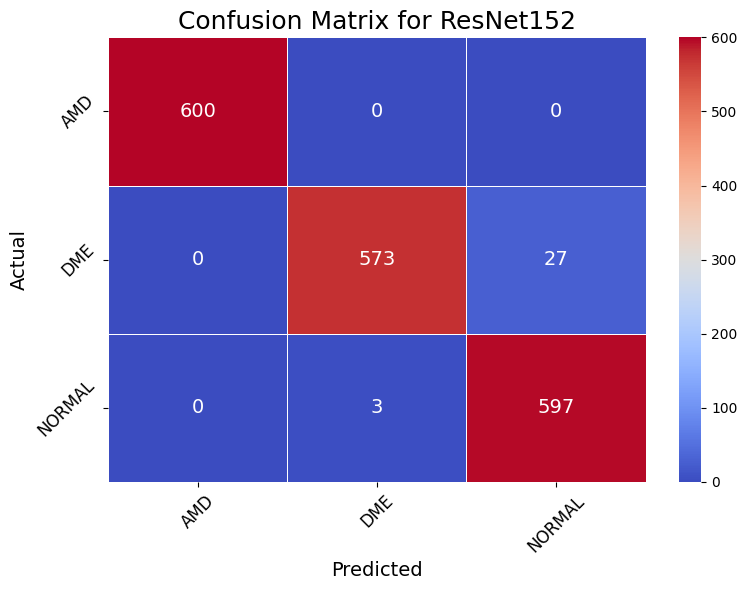


Evaluating InceptionV3
57/57 ━━━━━━━━━━━━━━━━━━━━ 14s 149ms/step

Classification Report for InceptionV3:

              precision    recall  f1-score   support

         AMD       1.00      1.00      1.00       600
         DME       0.99      0.97      0.98       600
      NORMAL       0.97      0.99      0.98       600

    accuracy                           0.98      1800
   macro avg       0.99      0.98      0.98      1800
weighted avg       0.99      0.98      0.98      1800



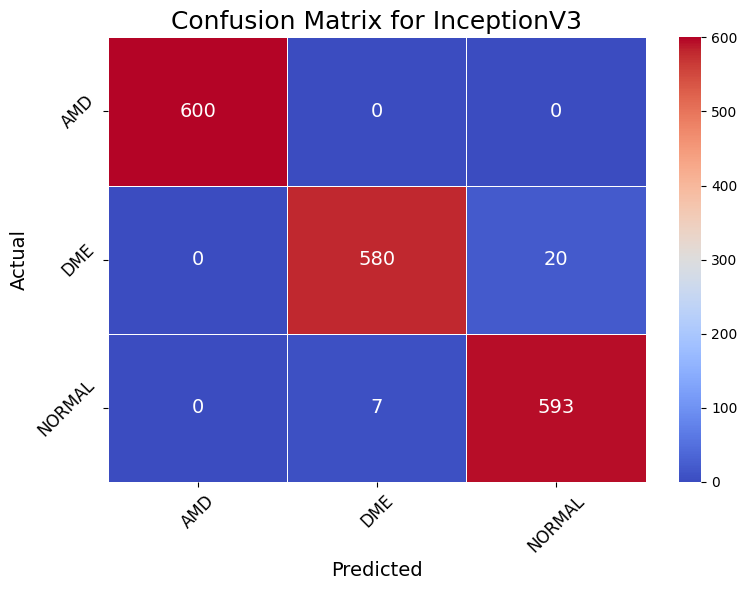


Evaluating MobileNetV2
57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 94ms/step

Classification Report for MobileNetV2:

              precision    recall  f1-score   support

         AMD       1.00      0.99      1.00       600
         DME       0.98      0.94      0.96       600
      NORMAL       0.94      0.99      0.96       600

    accuracy                           0.97      1800
   macro avg       0.97      0.97      0.97      1800
weighted avg       0.97      0.97      0.97      1800



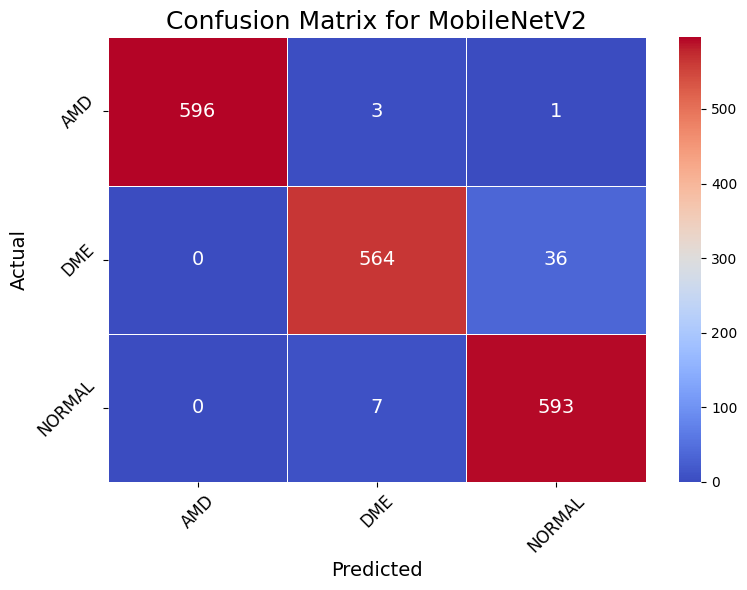

In [14]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

reports = {}

for name in trained_models:
    print(f"\nEvaluating {name}")
    
    model = tf.keras.models.load_model(model_paths[name])
    predictions = model.predict(test_generator)
    y_pred = np.argmax(predictions, axis=1)
    y_true = test_generator.classes

    #CLASSIFICATION REPORT
    report = classification_report(
        y_true,
        y_pred,
        target_names=list(test_generator.class_indices.keys()),
        output_dict=True
    )
    reports[name] = report

    print(f"\nClassification Report for {name}:\n")
    print(classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys())))

    #CONFUSION MATRIX
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", cbar=True, linewidths=0.5,
                annot_kws={"size": 14},
                xticklabels=list(test_generator.class_indices.keys()),
                yticklabels=list(test_generator.class_indices.keys()))

    plt.title(f"Confusion Matrix for {name}", fontsize=18)
    plt.xlabel("Predicted", fontsize=14)
    plt.ylabel("Actual", fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(rotation=45, fontsize=12)
    plt.tight_layout()
    plt.show()

# 🔍 Comparing Models Performance

In [15]:
summary_df = pd.DataFrame()
for name, report in reports.items():
    acc = report['accuracy']
    macro_avg = report['macro avg']

    summary_df[name] = {
        "Accuracy": acc,
        "Precision (macro avg)": macro_avg["precision"],
        "Recall (macro avg)": macro_avg["recall"],
        "F1-score (macro avg)": macro_avg["f1-score"]
    }

summary_df = summary_df.T
summary_df_sorted = summary_df.sort_values(by="Accuracy", ascending=False)
summary_df_sorted

,Accuracy,Precision (macro avg),Recall (macro avg),F1-score (macro avg)
InceptionV3,0.985000,0.985150,0.985000,0.984998
ResNet152,0.983333,0.983841,0.983333,0.983327
MobileNetV2,0.973889,0.974616,0.973889,0.973900
